# Data Exploration

In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# creating a map of team abbreviations to full names

team_map = { 'ATL': 'Atlanta Hawks', 'BOS': 'Boston Celtics', 'BKN': 'Brooklyn Nets',
             'CHI': 'Chicago Bulls', 'CHA': 'Charlotte Hornets', 'CLE': 'Cleveland Cavaliers',
             'DAL': 'Dallas Mavericks', 'DEN': 'Denver Nuggets', 'DET': 'Detroit Pistons',
             'GSW': 'Golden State Warriors', 'HOU': 'Houston Rockets', 'IND': 'Indiana Pacers',
             'LAC': 'Los Angeles Clippers', 'LAL': 'Los Angeles Lakers', 'MEM': 'Memphis Grizzlies',
             'MIA': 'Miami Heat', 'MIL': 'Milwaukee Bucks', 'MIN': 'Minnesota Timberwolves',
             'NOP': 'New Orleans Pelicans', 'NYK': 'New York Knicks', 'OKC': 'Oklahoma City Thunder',
             'ORL': 'Orlando Magic', 'PHI': 'Philadelphia 76ers', 'PHX': 'Phoenix Suns',
             'POR': 'Portland Trail Blazers', 'SAC': 'Sacramento Kings', 'SAS': 'San Antonio Spurs',
             'TOR': 'Toronto Raptors', 'UTA': 'Utah Jazz',  'WAS': 'Washington Wizards' }

# Cleanup and Formatting of data

In [3]:
# reading in the raw data and tweaking it a bit
df = pd.read_csv(Path("../../data/raw/nba_2008-2025_RAW.csv"))
df = df.drop(["moneyline_home", "moneyline_away", "h2_spread", "h2_total"], axis=1, errors='ignore')
df = df.dropna(how='any')
df

,season,date,regular,playoffs,away,home,score_away,score_home,q1_away,q2_away,...,q1_home,q2_home,q3_home,q4_home,ot_home,whos_favored,spread,total,id_spread,id_total
0,2008,2007-10-30,True,False,por,sa,97,106,26,23,...,29,30,22,25,0,home,13.0,189.5,0.0,1
1,2008,2007-10-30,True,False,utah,gs,117,96,28,34,...,30,21,21,24,0,home,1.0,212.0,0.0,1
2,2008,2007-10-30,True,False,hou,lal,95,93,16,27,...,25,18,19,31,0,away,5.0,199.0,0.0,0
3,2008,2007-10-31,True,False,phi,tor,97,106,22,28,...,24,34,23,25,0,home,6.5,191.0,1.0,1
4,2008,2007-10-31,True,False,wsh,ind,110,119,23,22,...,28,20,22,33,16,away,1.5,203.5,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23113,2025,2025-06-11,False,True,okc,ind,107,116,32,28,...,24,40,20,32,0,away,4.5,225.5,0.0,0
23114,2025,2025-06-13,False,True,okc,ind,111,104,34,23,...,35,25,27,17,0,away,6.5,227.5,1.0,0
23115,2025,2025-06-16,False,True,ind,okc,109,120,22,23,...,32,27,28,33,0,home,8.5,223.5,1.0,1
23116,2025,2025-06-19,False,True,okc,ind,91,108,25,17,...,28,36,26,18,0,away,5.5,222.5,0.0,0


In [4]:
# want to save a df for each season

seasons = df['season'].unique()
for season in seasons:
    season_df = df[df['season'] == season]
    season_df.columns = season_df.columns.str.lower()
    season_df.to_csv(Path(f"../../data/interim/nba_{season}_CLEANED.csv"), index=False)

# as well as a cleaned version of the full dataset
df.to_csv(Path("../../data/interim/nba_ALL_SEASONS_CLEANED.csv"), index=False)

In [8]:
# reading in the nba_api data
# should be run once to get the raw data from the API
from nba_api.stats.endpoints import leaguegamefinder

def load_api_data():
    """
    Pulling data from the nba_api for each season from 2008 to 2025 and saving it as a csv.
    2008 is the first season with spread and total data.
    """
    # saving each year from the API to a csv
    for season in seasons:
        if not Path(f"../../data/raw/nba_api_{season}_RAW.csv").exists():
            if season % 100 < 10:
                season_tag = f'{season-1}-0{season % 100}'
            else: 
                season_tag = f'{season-1}-{season % 100}'

            season_api = leaguegamefinder.LeagueGameFinder(season_nullable=season_tag, league_id_nullable='00')
            df = season_api.get_data_frames()[0]        
            df.columns = df.columns.str.lower()
            df.to_csv(Path(f"../../data/raw/nba_api_{season}_RAW.csv"), index=False)

if Path("../../data/raw/nba_ALL_SEASONS_API_RAW.csv").exists():
    print("API data already exists. Skipping data pull.")
elif all(Path(f"../../data/raw/nba_api_{season}_RAW.csv").exists() for season in seasons):
    print("All individual season API data files exist. Combining into one file.")
    api_dfs = []
    for season in seasons:
        api_df = pd.read_csv(Path(f"../../data/raw/nba_api_{season}_RAW.csv"))
        api_dfs.append(api_df)

    full_api_df = pd.concat(api_dfs, ignore_index=True)
    full_api_df.to_csv(Path("../../data/raw/nba_ALL_SEASONS_API_RAW.csv"), index=False)
else:
    load_api_data()

All individual season API data files exist. Combining into one file.


In [9]:
def clean_API_data(df):
    """
    Cleans up discrepancies between data pulled from .csv and nba_api.
    In general, we match to the format of the .csv data.
    """
    df = df.copy()

    # remove null entries
    df = df.dropna(how='any')
    
    # need to change their abbreviations
    df['team_abbreviation'] = df['team_abbreviation'].replace({'NJN': 'BKN', 'NOH': 'NOP', 'SEA': 'OKC', 'CHO': 'CHA'})
    # lets make the abreviations uppercase for consistency (just in case lowercase ones show up)
    df['team_abbreviation'] = df['team_abbreviation'].str.upper()

    # make team names match value from team_map
    df['team_name'] = df['team_abbreviation'].map(team_map)

    # drop any rows that don't have a valid team abbreviation
    df = df.dropna(subset=['team_abbreviation', 'team_name'])

    # change some column names for consistency with the other dataset
    df = df.rename(columns={'season_id': 'season', 'PTS': 'points', 'game_date': 'date'})

    # filtering to only actual games between two teams (no all-star/preseason games)
    df = df[df['team_id'].astype(str).str.contains('127')] # the 127 is a common value found for actual teams, not All-star/preseason games
    df = df[df['game_id'].duplicated(keep=False)]   # since each line corresponds to a single team, we remove all of the entries that don't have a matching team
                                                                # this is mostly cleanup from all games that have a team whose ID doesn't contain '127'                                                    

    df = df.sort_values(by='date') # sorting for consistency with CSV data

    df = df.drop(columns=['team_id', 'team_name', 'min', 'plus_minus'])

    return df

In [10]:
# cleaning the API data a bit
for season in seasons:
    api_df = pd.read_csv(Path(f"../../data/raw/nba_api_{season}_RAW.csv")) 

    api_df = clean_API_data(api_df)    

    print(api_df.head())
    api_df.to_csv(Path(f"../../data/interim/nba_api_{season}_CLEANED.csv"), index=False)

full_api_df = pd.read_csv(Path("../../data/raw/nba_ALL_SEASONS_API_RAW.csv"))
full_api_df = clean_API_data(full_api_df)
full_api_df.to_csv(Path("../../data/interim/nba_ALL_SEASONS_API_CLEANED.csv"), index=False)

      season team_abbreviation   game_id        date      matchup wl  pts  \
2850   12007               BOS  10700001  2007-10-06  BOS vs. TOR  W   89   
2848   12007               TOR  10700001  2007-10-06    TOR @ BOS  L   85   
2844   12007               ORL  10700005  2007-10-08  ORL vs. ATL  L   93   
2843   12007               DET  10700006  2007-10-08  DET vs. MIA  W  103   
2842   12007               ATL  10700005  2007-10-08    ATL @ ORL  W   94   

      fgm  fga  fg_pct  ...  fta  ft_pct  oreb  dreb  reb  ast  stl  blk  tov  \
2850   35   76   0.461  ...   23   0.696    10    37   47   20    4    2   18   
2848   33   85   0.388  ...   16   0.625     9    32   41   21    8    2   12   
2844   38   92   0.413  ...   25   0.560    15    34   49   22    6    6   15   
2843   34   71   0.479  ...   42   0.714    13    33   46   23    9    4   15   
2842   29   71   0.408  ...   47   0.702     6    33   39   19    8    9   14   

      pf  
2850  19  
2848  23  
2844  29  
2843  

In [11]:
# some formatting for csv data
merged_dfs = []
for season in seasons:
    csv_df = pd.read_csv(Path(f"../../data/interim/nba_{season}_CLEANED.csv"))

    # not much to do aside from changing the case of the team abbreviations
    csv_df['away'] = csv_df['away'].str.upper()
    csv_df['home'] = csv_df['home'].str.upper()

    csv_df['away'] = csv_df['away'].replace({'NO': 'NOP', 'SA': 'SAS', 'NY': 'NYK', 'GS': 'GSW', 'UTAH': 'UTA', "WSH": "WAS"})
    csv_df['home'] = csv_df['home'].replace({'NO': 'NOP', 'SA': 'SAS', 'NY': 'NYK', 'GS': 'GSW', 'UTAH': 'UTA', "WSH": "WAS"})

    csv_df.to_csv(Path(f"../../data/interim/nba_{season}_CLEANED.csv"), index=False)
    merged_dfs.append(csv_df)

full_merged_df = pd.concat(merged_dfs, ignore_index=True)
full_merged_df.to_csv(Path("../../data/interim/nba_ALL_SEASONS_CLEANED.csv"), index=False)

In [12]:
# expanding the csv data to have a row for each team in each game, mirroring the format of the API data
full_csv_df = pd.read_csv(Path("../../data/interim/nba_ALL_SEASONS_CLEANED.csv"))

# Create a new DataFrame with duplicated entries for home_team = 0 and home_team = 1
df_home = full_csv_df.copy()
df_home['home_team'] = 1

df_away = full_csv_df.copy()
df_away['home_team'] = 0

full_csv_df_expanded = pd.concat([df_home, df_away], ignore_index=True)

full_csv_df_expanded['team_abbreviation'] = full_csv_df_expanded.apply(lambda row: row['home'] if row['home_team'] == 1 else row['away'], axis=1)
full_csv_df_expanded['points'] = full_csv_df_expanded.apply(lambda row: row['score_home'] if row['home_team'] == 1 else row['score_away'], axis=1)
full_csv_df_expanded = full_csv_df_expanded.sort_values(by=['date', 'home', 'team_abbreviation'])

full_csv_df_expanded = full_csv_df_expanded.drop(columns=['home', 'away', 'score_home', 'score_away']).sort_values(by=['date', 'home_team', 'team_abbreviation'])

full_csv_df_expanded.to_csv(Path("../../data/interim/nba_ALL_SEASONS_CLEANED_EXPANDED.csv"), index=False)

In [13]:
# some cleanup and expansion of the API data
full_api_df = pd.read_csv(Path("../../data/interim/nba_ALL_SEASONS_API_CLEANED.csv"))

full_api_df['home_team'] = full_api_df['matchup'].str.contains('vs').astype(int)

full_api_df = full_api_df.drop(columns=['matchup'])

full_api_df.to_csv(Path("../../data/interim/nba_ALL_SEASONS_API_CLEANED_EXPANDED.csv"), index=False)

In [14]:
def match_games(api_df, csv_df):
    """
    Matches games between api_df and csv_df based on 'date' and 'team_abbreviation'.
    Returns a merged DataFrame with suffixes to distinguish columns from each source.
    """
    merged = pd.merge(
        api_df,
        csv_df,
        left_on=['date', 'team_abbreviation'],
        right_on=['date', 'team_abbreviation'],
        suffixes=('_api', '_csv'),
        how='inner'
    )
    return merged

# Example usage:
matched_df = match_games(full_api_df, full_csv_df_expanded)
matched_df = matched_df.rename(columns={'home_team_api': 'home_team'})
matched_df = matched_df.drop(columns=['season_api', 'season_csv', 'home_team_csv', 'points'])
matched_df = matched_df.sort_values(by=['game_id'])
matched_df.to_csv(Path("../../data/processed/nba_ALL_SEASONS_MATCHED.csv"), index=False)

# Data Exploration Time

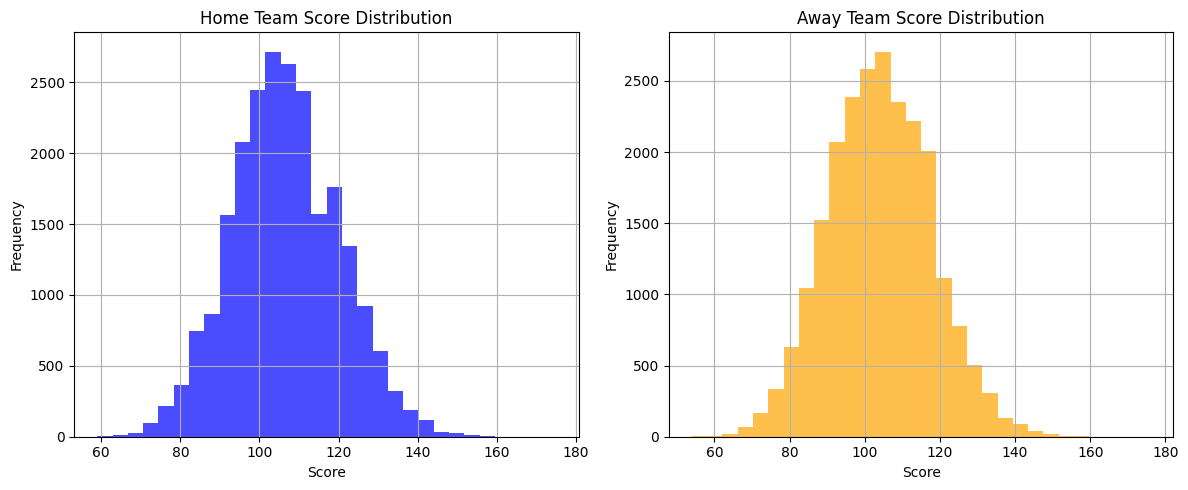

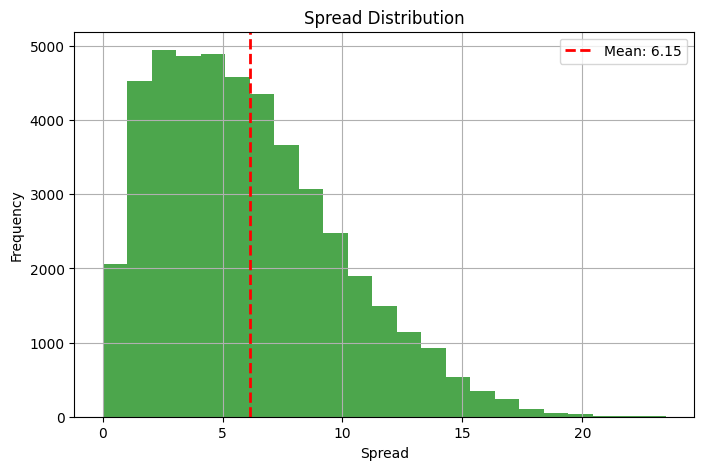

In [19]:
import matplotlib.pyplot as plt

df = pd.read_csv(Path("../../data/processed/nba_ALL_SEASONS_MATCHED.csv"))

# Distribution of total points scored by home and away teams
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df[df['home_team'] == 1]['pts'].hist(bins=30, alpha=0.7, color='blue')
plt.title('Home Team Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df[df['home_team'] == 0]['pts'].hist(bins=30, alpha=0.7, color='orange')
plt.title('Away Team Score Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Spread distribution
plt.figure(figsize=(8, 5))
df['spread'].hist(bins=int(df['spread'].max()), color='green', alpha=0.7)
plt.axvline(df['spread'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {df["spread"].mean():.2f}')
plt.legend()
plt.title('Spread Distribution')
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.show()

# Correlation matrix
# plt.figure(figsize=(10, 8))
# corr = df[['pts','fgm','fga','fg_pct','fg3m','fg3a','fg3_pct','ftm','fta','ft_pct',
#             'oreb','dreb','reb','ast','stl','blk','tov','pf','q1_away','q2_away','q3_away',
#             'q4_away','ot_away','q1_home','q2_home','q3_home','q4_home','ot_home','id_spread','id_total']].corr()
# print(df.info())
# plt.matshow(corr, fignum=1, cmap='inferno')
# plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
# plt.yticks(range(len(corr.columns)), corr.columns)
# for (i, col1) in enumerate(corr.columns):
#     for (j, col2) in enumerate(corr.columns):
#         if corr.iloc[i, j] > 0.25 and i != j:
#             plt.text(j, i, f"{corr.iloc[i, j]:.2f}", va='center', ha='center', color='black', fontsize=6)
# plt.colorbar()
# plt.title('Correlation Matrix', pad=20)
# plt.show()
